In [1]:
from utils import *

In [2]:
def parse_timestamps(df):
    '''
    It looks like the visit_timestamp is a duplicate of the visit_date, so we'll
    drop it and parse visit_date instead. Same deal for the event_time and
    event_timestamp columns.
    '''
    return df.assign(
        visit_date=pd.to_datetime(df['visit_date'], format='%Y-%m-%dT%H:%M:%S'),
        event_time=pd.to_datetime(df['event_time'], format='mixed'),
    ).drop(columns=['visit_timestamp', 'event_timestamp'])

In [3]:
def split_coordinates(df):
    """
    Split the coordinates column into separate latitude and longitude columns.
    """
    df = df.copy()
    df[['longitude', 'latitude']] = df['coordinates'].str.split(',', expand=True)
    df['longitude'] = df['longitude'].astype(np.float32)
    df['latitude'] = df['latitude'].astype(np.float32)
    return df

In [4]:
new_names = {
    'Vehicle#': 'vehicle_id',
    'District': 'district',
    'Column1.visit_date': 'visit_date',
    'Column1.visit_date.date.time': 'visit_timestamp',
    'Column1.control_group_data': 'control_group',
    'Column1.workzone_id': 'workzone_id',
    'Column1.cause': 'cause',
    'Column1.message': 'message',
    'Column1.points.features.geometry.coordinates': 'coordinates',
    'Column1.points.features.properties.speed': 'speed',
    'Column1.points.features.properties.bearing': 'bearing',
    'Column1.points.features.properties.timestamp': 'event_time',
    'Column1.points.features.properties.timestamp.date.time': 'event_timestamp',
    'Column1.points.features.properties.accel': 'acceleration',
    'Column1.points.features.properties.brake_avg': 'brake_average',
    'Column1.points.features.properties.brake_max': 'brake_maximum',
    'Column1.points.features.properties.brake_start': 'brake_start',
    'Column1.points.features.properties.brake_stop': 'brake_stop'
}
column_names = list(new_names.values())

In [5]:
# Specifying these dtypes takes memory usage down from 3GB to 700MB!
dtype_spec = {
    'vehicle_id': pd.UInt32Dtype(),
    'district': pd.UInt8Dtype(), 
    'control_group': bool,
    'speed': np.float32,
    'bearing': np.float32,
    'acceleration': np.float32,
    'brake_average': np.float32,
    'brake_maximum': np.float32,
    'brake_start': np.float32,
    'brake_stop': np.float32
}

In [6]:
df = (
    pd.read_csv('data.csv', names=column_names, skiprows=1,
                dtype=dtype_spec)
    .pipe(parse_timestamps)
    .pipe(split_coordinates)
)
df

,vehicle_id,district,visit_date,control_group,...,brake_start,brake_stop,longitude,latitude
0,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.05,32.67
1,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
2,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
...,...,...,...,...,...,...,...,...,...
9665540,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18
9665541,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18
9665542,251592,11,2024-12-23 23:59:45,False,...,NaN,NaN,-117.35,33.18


In [7]:
display_df(df.iloc[0].to_frame(), rows=18)

,0
vehicle_id,210821
district,11
visit_date,2024-11-23 00:00:33
control_group,False
workzone_id,8-7483
cause,Miscellaneous Work
message,Slow down.
coordinates,"-117.0457137,32.669405"
speed,59.4
bearing,237.0


In [8]:
df['vehicle_id'].nunique()

33594

In [9]:
df['district'].value_counts()

district
11    6301007
2     3364536
Name: count, dtype: Int64

In [10]:
df['visit_date'].describe()

count                          9665543
mean     2024-12-09 07:51:28.343904512
min                2024-11-23 00:00:33
25%                2024-12-04 12:40:18
50%                2024-12-09 20:45:14
75%                2024-12-16 19:15:06
max                2024-12-23 23:59:45
Name: visit_date, dtype: object

In [11]:
df['control_group'].value_counts()

control_group
False    7885283
True     1780260
Name: count, dtype: int64

In [12]:
df['message'].value_counts()

message
Slow down.           4043241
Right Lane Closed    2422055
Left Lane Closed     1410213
Name: count, dtype: int64

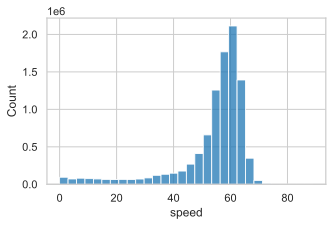

In [19]:
plt.figure(figsize=(5, 3))
sns.histplot(data=df, x='speed', bins=30);

## Plotting individual vehicle data

In [55]:
v1

,vehicle_id,district,visit_date,control_group,...,brake_start,brake_stop,longitude,latitude
0,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.05,32.67
1,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
2,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
...,...,...,...,...,...,...,...,...,...
282,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
283,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66
284,210821,11,2024-11-23 00:00:33,False,...,NaN,NaN,-117.09,32.66


In [57]:
# For some reason, every vehicle_id has a unique visit_date, which either
# implies that no vehicles reappeared in this study, or that vehicle_ids might
# be reassigned each time a vehicle is recorded (perhaps for anonymity?)

slider = widgets.SelectionSlider(
    options=df['vehicle_id'].unique(),
)
@widgets.interact(vehicle_id=slider)
def plot_vehicle_data(vehicle_id):
    v1 = df.query('vehicle_id == @vehicle_id')
    plt.figure(figsize=(6, 3))
    sns.lineplot(data=v1, x='event_time', y='speed')

    plt.axhline(y=55, color='black', linestyle=':', label='Speed Limit')
    plt.axhline(y=0, color='black', linestyle=':', label='Zero Speed')
    
    # Customize the plot
    is_control = 'Control' if v1['control_group'].iloc[0] else 'Test'
    plt.title(f'Speed vs Time for Vehicle {vehicle_id} ({is_control})')
    plt.xlabel('Time')
    plt.ylabel('Speed (mph)')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

interactive(children=(SelectionSlider(description='vehicle_id', options=(np.uint32(210821), np.uint32(211148),…

In [91]:
import matplotlib.dates as mdates

def plot_vehicle_sparklines(vehicle_ids, ncols_per_group=2):
    """
    Create compact sparkline-style plots with control vehicles on the left and test vehicles on the right.
    
    Args:
        vehicle_ids: List of vehicle IDs to plot
        ncols_per_group: Number of columns for each group (control/test)
    """
    # Separate vehicles into control and test groups
    control_vehicles = []
    test_vehicles = []
    
    for vid in vehicle_ids:
        is_control = df.query('vehicle_id == @vid')['control_group'].iloc[0]
        if is_control:
            control_vehicles.append(vid)
        else:
            test_vehicles.append(vid)
    
    # Calculate number of rows needed (use max of control and test group sizes)
    nrows = max(
        (len(control_vehicles) + ncols_per_group - 1) // ncols_per_group,
        (len(test_vehicles) + ncols_per_group - 1) // ncols_per_group
    )
    
    # Total number of columns is doubled (ncols_per_group for each group)
    total_cols = ncols_per_group * 2
    
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=total_cols,
                           figsize=(2*total_cols, 1*nrows),
                           squeeze=False)
    
    def plot_vehicle(vehicle_id, ax):
        """Helper function to create individual sparkline plot"""
        v1 = df.query('vehicle_id == @vehicle_id')
        
        # Create the sparkline plot
        sns.lineplot(data=v1, x='event_time', y='speed', ax=ax, linewidth=1)
        
        # Add reference lines
        ax.axhline(y=55, color='black', linestyle=':', linewidth=0.5, alpha=0.5)
        ax.axhline(y=0, color='black', linestyle=':', linewidth=0.5, alpha=0.5)
        
        # Customize the plot
        is_control = 'Control' if v1['control_group'].iloc[0] else 'Test'
        ax.set_title(f'Vehicle {vehicle_id}\n({is_control})', fontsize=8)
        
        # Remove labels and ticks for compactness
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='both', length=0, labelsize=6)
        
        # Format datetime ticks more compactly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    
    # Plot control vehicles in left columns
    for idx, vid in enumerate(control_vehicles):
        row = idx // ncols_per_group
        col = idx % ncols_per_group
        if row < nrows:  # Only plot if we have room
            plot_vehicle(vid, axs[row, col])
    
    # Plot test vehicles in right columns
    for idx, vid in enumerate(test_vehicles):
        row = idx // ncols_per_group
        col = (idx % ncols_per_group) + ncols_per_group  # Offset to right side
        if row < nrows:  # Only plot if we have room
            plot_vehicle(vid, axs[row, col])
    
    # Hide empty subplots
    for row in range(nrows):
        for col in range(total_cols):
            # Check if this subplot position should have a plot
            control_idx = row * ncols_per_group + col
            test_idx = row * ncols_per_group + (col - ncols_per_group)
            
            if (col < ncols_per_group and control_idx >= len(control_vehicles)) or \
               (col >= ncols_per_group and test_idx >= len(test_vehicles)):
                axs[row, col].set_visible(False)
    
    # Add group labels at the top
    # fig.suptitle('Control Vehicles                    Test Vehicles', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)  # Make room for suptitle
    return fig

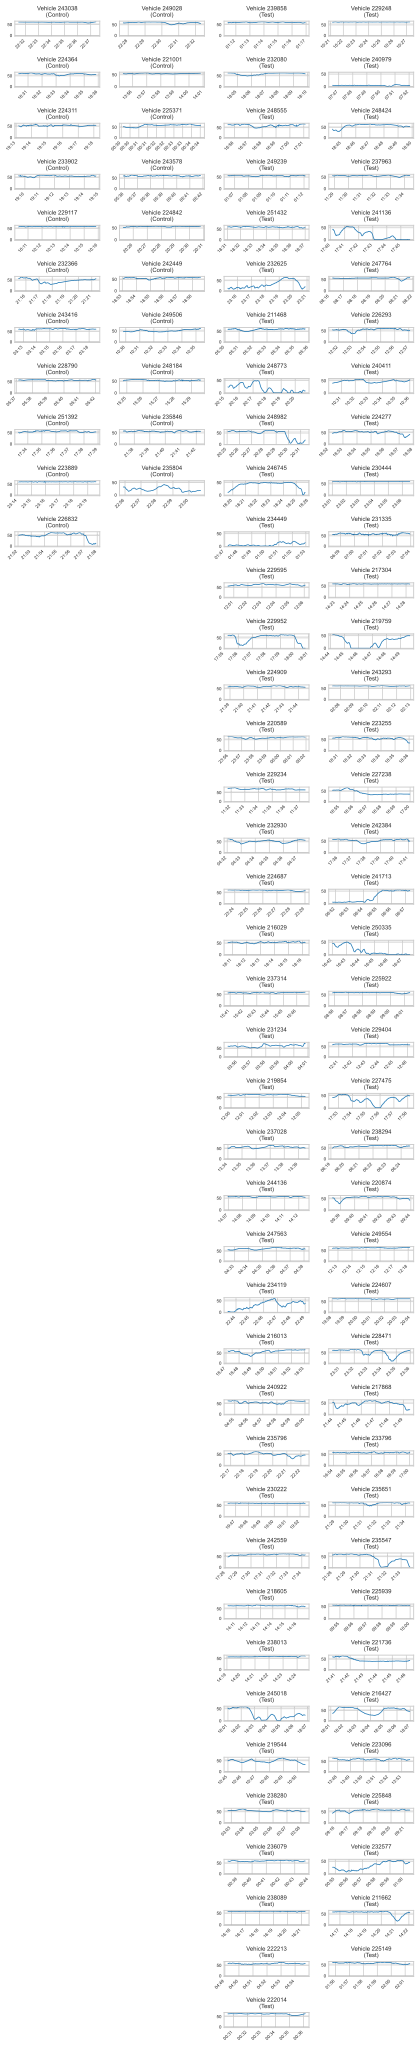

CPU times: user 7.9 s, sys: 1.38 s, total: 9.28 s
Wall time: 9.32 s


In [93]:
%%time
sample_ids = np.random.choice(df['vehicle_id'].unique(), size=100, replace=False)
fig = plot_vehicle_sparklines(sample_ids)

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('vehicle_sparklines.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')
plt.show()